In [23]:
import pandas as pd
import numpy as np
from collections import defaultdict



In [24]:
df = pd.read_csv('attribution data.csv')
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [26]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


## data

- Cookie: Randomly generated customer id enabling us to tie subsequent visits back to the same customer
- Timestamp: Date and time when the visit took place
- Interaction: Categorical variable indicating the type of interaction that took place
- Conversion: Boolean variable indicating whether a conversion took place
- Conversion Value: Value of the potential conversion event
- Channel: The marketing channel that brought the customer to our site

In [27]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
    
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

df_paths['path'] = np.where(
    df_paths['conversion'] == 0,
    ['Start'] + df_paths['channel'] + ['Null'],
    ['Start'] + df_paths['channel'] + ['Conversion'])

df_paths = df_paths[['cookie', 'path']]

In [29]:
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, Paid Search, Null]"


## STEPS
- Calculate transition probabilities between all states in our state-space
- Calculate removal effects

In [30]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [31]:
base_conversion_rate

0.07346277508454528

## identifies all potential state transitions and outputs a dictionary containing these

In [32]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states

In [33]:
trans_states = transition_states(list_of_paths)

In [34]:
trans_states

{'Null>Null': 0,
 'Null>Online Display': 0,
 'Null>Online Video': 0,
 'Null>Paid Search': 0,
 'Null>Facebook': 0,
 'Null>Conversion': 0,
 'Null>Instagram': 0,
 'Null>Start': 0,
 'Online Display>Null': 32236,
 'Online Display>Online Display': 0,
 'Online Display>Online Video': 737,
 'Online Display>Paid Search': 3936,
 'Online Display>Facebook': 2300,
 'Online Display>Conversion': 2144,
 'Online Display>Instagram': 1251,
 'Online Display>Start': 0,
 'Online Video>Null': 31285,
 'Online Video>Online Display': 775,
 'Online Video>Online Video': 0,
 'Online Video>Paid Search': 1964,
 'Online Video>Facebook': 2430,
 'Online Video>Conversion': 3201,
 'Online Video>Instagram': 1307,
 'Online Video>Start': 0,
 'Paid Search>Null': 68476,
 'Paid Search>Online Display': 4269,
 'Paid Search>Online Video': 2596,
 'Paid Search>Paid Search': 0,
 'Paid Search>Facebook': 5725,
 'Paid Search>Conversion': 4736,
 'Paid Search>Instagram': 3038,
 'Paid Search>Start': 0,
 'Facebook>Null': 59319,
 'Facebook>O

## calculate all transition probabilities

In [35]:

def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob




In [36]:
trans_prob = transition_prob(trans_states)

In [37]:
trans_prob

defaultdict(dict,
            {'Online Display>Null': 0.7566425687728852,
             'Online Display>Online Video': 0.017298845178856444,
             'Online Display>Paid Search': 0.09238569148436766,
             'Online Display>Facebook': 0.053985541263731104,
             'Online Display>Conversion': 0.05032391324758239,
             'Online Display>Instagram': 0.02936344005257722,
             'Online Video>Null': 0.7637566525072018,
             'Online Video>Online Display': 0.018919974610614718,
             'Online Video>Paid Search': 0.04794687759386749,
             'Online Video>Facebook': 0.059323275230701626,
             'Online Video>Conversion': 0.0781455983594551,
             'Online Video>Instagram': 0.03190762169815927,
             'Paid Search>Null': 0.7707789284106259,
             'Paid Search>Online Display': 0.04805267897343539,
             'Paid Search>Online Video': 0.029221071589374155,
             'Paid Search>Facebook': 0.06444169293111211,
         

### identify removal effects for each of our marketing channels. To do this we’ll make use of linear algebra and matrix manipulations

In [38]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix




In [39]:
trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [40]:
trans_matrix

,Null,Online Display,Online Video,Paid Search,Facebook,Conversion,Instagram,Start
Null,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Online Display,0.756643,0.000000,0.017299,0.092386,0.053986,0.050324,0.029363,0.0
Online Video,0.763757,0.018920,0.000000,0.047947,0.059323,0.078146,0.031908,0.0
Paid Search,0.770779,0.048053,0.029221,0.000000,0.064442,0.053309,0.034196,0.0
Facebook,0.673123,0.024352,0.025577,0.050655,0.000000,0.053220,0.173072,0.0
Conversion,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
Instagram,0.629786,0.023531,0.024118,0.045809,0.218777,0.057979,0.000000,0.0
Start,0.000000,0.142644,0.142361,0.317399,0.278408,0.000000,0.119188,0.0


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


df=trans_matrix


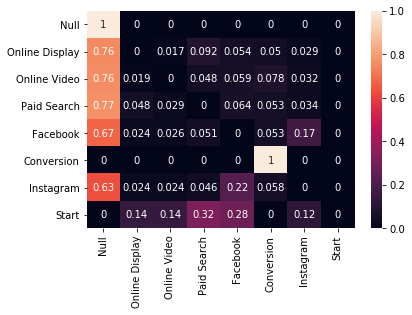

In [45]:
sns.heatmap(df, annot=True)

### iteratively go through each of our channels and assess the impact it would have on overall conversion if we were to remove a channel from our state-space

In [46]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict

In [47]:
removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)


In [48]:
removal_effects_dict

{'Online Display': 0.15435482356041286,
 'Online Video': 0.2069141165564219,
 'Paid Search': 0.3311037560086154,
 'Facebook': 0.3547597674182721,
 'Instagram': 0.21731366149038445}

In [49]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}




In [50]:
attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [51]:
attributions

{'Online Display': 2153.2469267590836,
 'Online Video': 2886.4480895461475,
 'Paid Search': 4618.891257291356,
 'Facebook': 4948.892177847523,
 'Instagram': 3031.5215485558915}

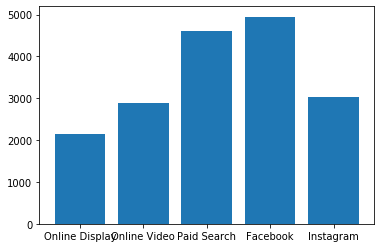

In [55]:
D=attributions
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()
